## Algorithm and environment designing in a one-period setting

In this notebook, we validate the theoretical result derived in our paper and the proposed environment design approaches.
To this end, we investigate the convergence behaviors of the learning algorithm when selecting the next environment, more specifically the choice of the environment $G_{n+1}$ at every round $n$, either fully at random or according to optimizing heuristically induced criteria for faster convergence.

For simplicity, here, we consider risk measures of the form
$$
\rho_{\mu}(X) = \int_{0}^{1} \text{CVaR}_{1-\alpha}(X) \mu( \textrm{d} \alpha),
$$
where $\mu = \gamma \delta_{0} + (1-\gamma) \delta_{\kappa}$.
This characterizes a trade-off between risk-aversion behaviors from the CVaR at level $\kappa$, and risk-seeking behaviors from the (risk-neutral) expectation.
We also consider cost functions $C$ that are either fully known or partially known, i.e. the learner only knows the values of the function.
The finite set of risk aversions $\Upsilon$ is thus composed of tuples $(C_{\ell}, \kappa_{\ell}, \gamma_{\ell})$.

We note that this notebook may be easily extended to other risk measures of this form, e.g. linear combinations of CVaRs at different thresholds, and larger state and action spaces.
In practice, we notice a decrease in convergence speed when using a larger state space, but no significant difference with more actions.

In [1]:
# load Python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import itertools
from time import time

### Definition of functions

The function `get_analytical_risk` returns the risk measure of the cost random variable obtained for a given environment.

In [2]:
def get_analytical_risk(upsilon, action, trans_probs):
    # sort costs in decreasing order
    sorted_costs = upsilon[2][np.argsort(upsilon[2][::-1])]
    sorted_pis = trans_probs[action,np.argsort(upsilon[2][::-1])]
    
    # compute CDF
    revd_cpis = np.cumsum(sorted_pis[::-1])
    
    kappa_cond = int(np.sum(upsilon[0] <= revd_cpis))
    
    # compute risk from expectation contribution
    risk_E = np.sum(sorted_pis*sorted_costs)
    
    # compute risk from CVaR contribution
    partial_risk_CVaR = np.array([sorted_costs[i]*(revd_cpis[-(i+1)] - revd_cpis[-(i+2)]) for i in range(kappa_cond-1)])
    risk_CVaR = (1/(1-upsilon[0]))*( \
                np.sum(partial_risk_CVaR) + sorted_costs[kappa_cond-1] * (revd_cpis[-(kappa_cond)] - upsilon[0]))
    
    # get risk of the linear combination
    risk = upsilon[1]*risk_E + (1-upsilon[1])*risk_CVaR

    return risk

Define the **regret** as

\begin{equation*}
\Phi(a;G,\ell) = \rho_{\mu_{\ell}}\Big(C_{\ell}(X^{a}_{G})\Big) - \min_{k \in \mathbb{A}} \rho_{\mu_{\ell}}\Big(C_{\ell}(X^{k}_{G})\Big).
\end{equation*}

It can be viewed as the regret of action $a$ under the environment $G$ and risk aversion $(C_{\ell}, \mu_{\ell})$.

In [3]:
def compute_regret(upsilons, G, a):
    phis = np.zeros(len(upsilons))
    n_actions = G.shape[0]
    
    for idx_upsilon, upsilon in enumerate(upsilons):
        # compute risk of upsilon for all actions
        risk = np.zeros(n_actions)
        for action in range(n_actions):
            risk[action] = get_analytical_risk(upsilon, action, G)
        
        # compute regret
        phis[idx_upsilon] = risk[a] - np.min(risk)
                
    return phis

Let $a^{*,\ell} = \arg\!\min_{k} \rho_{\mu_{\ell}}\Big(C_{\ell}(X^{k}_{G})\Big)$ be the optimal action under the risk aversion $(C_{\ell}, \mu_{\ell})$. Define the **distinguishing power** as
\begin{align*}
\Psi(G;i,j) &= - \Phi(a^{*,j};G,i) \Phi(a^{*,i};G,j)\\
&= - \Phi(1;G,i) \Phi(2;G,j) - \Phi(2;G,i) \Phi(1;G,j).
\end{align*}

In [4]:
def compute_power(Gs, upsilons, progress=False):
    psis = np.zeros((len(Gs), len(upsilons), len(upsilons)))
    n_actions = Gs.shape[1]
    
    # loop for each environent
    for idx_G, G in enumerate(Gs):
        if progress:
            print("\rPower computation: environment #{:5d} of {:5d}".format(idx_G+1, len(Gs)), end="")
        
        a_star = np.zeros(len(upsilons), dtype=int)
        
        # loop for each criterion
        for idx_upsilon, upsilon in enumerate(upsilons):
            # compute A^{*} for upsilon
            risk = np.zeros(n_actions)
            for action in range(n_actions):
                risk[action] = get_analytical_risk(upsilon, action, G)
            a_star[idx_upsilon] = np.argmin(risk)
            
        # loop for each criterion
        for idx_upsilon1, upsilon1 in enumerate(upsilons):
            # loop for other criterion
            for idx_upsilon2, upsilon2 in enumerate(upsilons):
                # make sure \psi(\lambda, \mu_i, \mu_i) is -\inf
                if idx_upsilon1 == idx_upsilon2:
                    psis[idx_G, idx_upsilon1, idx_upsilon1] = -np.inf
                else:
                    # get regret for all criteria
                    phi1 = compute_regret([upsilon1], G, a_star[idx_upsilon2])
                    phi2 = compute_regret([upsilon2], G, a_star[idx_upsilon1])

                    # compute the power
                    ### psis[idx_G, idx_upsilon1, idx_upsilon2] = -1 * phi1 * phi2 ### deprecated
                    psis[idx_G, idx_upsilon1, idx_upsilon2] = -1 * phi1.item() * phi2.item()
                
    if progress:
        print(" Done.")
    return psis

The `select_next_G` function determines which transition probability matrix to use according to three different methods:

- **"random"** randomly selects an environment
- **"largest"** selects the next environment according to
\begin{equation*}
G_{N+1} \in \arg\!\min_{G\in\mathcal{P}(\mathbb{X})^\mathbb{A}} \Psi(G,i^*_N,j^*_N) ,
\end{equation*}
where $(i^*_N,j^*_N)$ is the pair of entries with the largest and second largest probabilities assigned by $\mathbb{Q}_N$.
- **"expected"** selects the next environment according to
\begin{align}\label{eq:DesignGBatch}
G_{N+1} \in \arg\!\min_{G\in\mathcal{P}(\mathbb{X})^\mathbb{A}} \mathbb{E}\left[ \Psi(G,\eta,\zeta) \right],
\end{align}
where $\eta\sim\mathbb{Q}_{N}$ and $\zeta\sim\mathbb{Q}_{N}|\zeta\neq\eta$.

In [5]:
def select_next_G(psis, upsilons, gibbs_meas, Gs, n_sims, method):
    if method=="random":
        next_G = np.random.randint(len(Gs))
    
    elif method=="largest":
        # obtain the two risk-aversions with the largest Gibbs value
        largest = np.partition(gibbs_meas, -2)[-2:]
        if largest[0] == largest[1]:
            upsilon_largest = np.random.choice(np.where(gibbs_meas == largest[1])[0], size=2)
        else:
            upsilon_largest = np.array([np.where(gibbs_meas == largest[1])[0][0],
                                        np.random.choice(np.where(gibbs_meas == largest[0])[0])])
        
        next_G = np.argmin( psis[ :, upsilon_largest[0], upsilon_largest[1]] )
       
    elif method=="expected":
        # sample two criteria (without replacement) according to the Gibbs measure
        upsilon_rand = np.stack([np.random.choice(len(upsilons),size=2,replace=False,p=gibbs_meas) for i in range(n_sims)])
        
        # compute the expectation of the difference in power
        expected_powers = np.zeros(len(Gs))
        for idx_G, G in enumerate(Gs):
            expected_powers[idx_G] = np.mean( psis[ idx_G, upsilon_rand[:,0], upsilon_rand[:,1]] )

        next_G = np.argmin(expected_powers)
        
    else:
        ValueError("Selection method is unknown ('random' or 'largest' or 'expected').")
        
    return next_G, Gs[next_G, ...]

The `learn` function runs the main learning algorithm.

In [6]:
def learn(Gs, # set of environments
          psis, # power for all environments
          upsilons, # set of criteria for the learner
          upsilon0, # criterion for the expert
          n_rounds, # number of rounds
          select_method, # string for the selection method when designing environments at each episode
          lr, # learning rate for the Gibbs measure
          print_progress=None): # number of episodes before printing the progress

    # initialize Gibbs measure
    phis_hat = np.zeros(len(upsilons))
    gibbs_meas = np.exp(phis_hat-np.max(phis_hat)) / np.sum(np.exp(phis_hat-np.max(phis_hat)))
    
    n_actions = Gs.shape[1]
    n_states = Gs.shape[2]
    
    gibbs = np.zeros((n_rounds, len(upsilons)))
    chosen_Gs = np.zeros((n_rounds, n_actions, n_states))
    
    # algorithm
    for k in range(n_rounds):

        # select the lambda with highest power
        _, G = select_next_G(psis, upsilons, gibbs_meas, Gs, n_sims=100, method=select_method)

        # get optimal action from analytical risk
        risk = np.zeros(n_actions)
        for action in range(n_actions):
            risk[action] = get_analytical_risk(upsilon0, action, G)
        opt_action = np.argmin(risk)

        # compute the potential/energy for all upsilons
        phis_k = compute_regret(upsilons, G, opt_action)

        # normalize the potentials
        phis_normalized = phis_k - np.mean(phis_k)

        # update sum of potentials
        phis_hat -= phis_normalized

        # update Gibbs measure (subtracting the maximum for numerical stability)
        gibbs_meas = np.exp(lr*(phis_hat-np.max(phis_hat))) / np.sum(np.exp(lr*(phis_hat-np.max(phis_hat))))
        
        # keep track of Gibbs measure and chosen environments
        gibbs[k,...] = gibbs_meas
        chosen_Gs[k,...] = G
        
        # print progress
        if (print_progress is not None) and (k % print_progress == 0 or k == n_rounds - 1):
            print("Episode: {:3d};".format(k+1),
                  "Best criterion: {:2d}".format(np.argmax(gibbs_meas) + 1),
                  "with kappa: {:.2f}".format(upsilons[np.argmax(gibbs_meas)][0]),
                  "  gamma: {:.2f}".format(upsilons[np.argmax(gibbs_meas)][1]),
                  "  cost function: ", np.array_str(upsilons[np.argmax(gibbs_meas)][2], precision=2))        
            print("Gibbs:", np.array_str(gibbs_meas, precision=2, suppress_small=True))
    
    return gibbs, chosen_Gs

### Initialization of hyperparameters

We use the following notation:
- A finite set of states $\mathbb{X}$ with $\text{n_states} := |\mathbb{X}| \geq 3$
- A finite set of actions $\mathbb{A}$ with $\text{n_actions} := |\mathbb{A}| \geq 2$
- A finite set of transition probabilities, denoted by $G$, with $\text{n_envs} := |G| > 0$.
- Finite sets of risk-aversion parameters $\mathcal{\kappa}$ and $\mathcal{\gamma}$ with $\kappa \in (0,1]$, $\gamma \in [0,1)$
- Whether a known cost function $C_{0}: \mathcal{X} \rightarrow \mathbb{R}$, or a partially unknown cost function $C_{\ell}: \mathcal{X} \rightarrow \mathbb{R}$, where we only know the values of the cost function
- A finite set of critera $\Upsilon$, denoted $\{\Upsilon_{\ell}\}_{\ell=1,\ldots,L}$ consisting of the tuples $\{\kappa_{\ell}, \gamma_{\ell}, C_{0}\}_{\ell}$ (if cost is known) or $\{\kappa_{\ell}, \gamma_{\ell}, C_{\ell}\}_{\ell}$ (if cost is partially unknown)

In [7]:
"""
EXPERT AND LEARNER PARAMETERS
"""
### set of experiments 1
upsilon0 = (0.3, 0.25, np.array([1.0, 0.5, 0.0]))
kappas = np.array([0.2, 0.3, 0.4, 0.5])
gammas = np.array([0.5, 0.25, 0.75])
unknown_cost = True
costs = np.array([[1.0, 0.5, 0.0],
                [0.5, 1.0, 0.0],
                [1.0, 0.0, 0.5]])

# ### set of experiments 2
# upsilon0 = (0.24, 0.0, np.array([1.0, 0.5, 0.0]))
# kappas = np.linspace(0.1, 0.9, 21)
# gammas = np.array([0.0])
# unknown_cost = False
# costs = np.array([[1.0, 0.5, 0.0]])

# ### set of experiments 3
# ...

upsilons = list(itertools.product(kappas, gammas, costs))

"""
ALGORITHM PARAMETERS
"""
# initialize the dimensions of each space
n_actions = 2 # number of actions
n_states = 3 # number of states
n_envs = 500 # number of environments
lr = 4 # learning rate

def cost_func(state, action, cost):
    return cost[state]

In [8]:
# validate all parameters
assert isinstance(n_actions, int) & (n_actions >= 0), "n_actions must be a positive integer."
assert isinstance(n_states, int) & (n_states >= 0), "n_states must be a positive integer."
assert isinstance(n_envs, int) & (n_envs >= 0), "n_envs must be a positive integer."
assert np.all((kappas > 0) & (kappas < 1)), "All kappas must be in (0,1)."
assert np.all((gammas >= 0) & (gammas < 1)), "All gammas must be in [0,1)."
assert len(upsilon0) == 3, "upsilon0 must contain a risk level kappa, a coefficient gamma, and a cost function."
print('*** All parameters are validated ***')

# print all criteria
print("Agent criterion --  kappa: {:.2f}".format(upsilon0[0]),
      "  gamma: {:.2f}".format(upsilon0[1]),
      "  cost function: ", np.array_str(upsilon0[2], precision=2))
print("--------------")
print('Criterion space (', 'unknown' if unknown_cost else 'known', ' cost):', sep='')
for idx, upsilon in enumerate(upsilons):
    print("Criterion #{:2d}".format(idx+1),
          " --  kappa: {:.3f}  ".format(upsilon[0]), 
          "  gamma: {:.3f}  ".format(upsilon[1]),
          "  cost function: ", np.array_str(upsilon[2], precision=2))

*** All parameters are validated ***
Agent criterion --  kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
--------------
Criterion space (unknown cost):
Criterion # 1  --  kappa: 0.200     gamma: 0.500     cost function:  [1.  0.5 0. ]
Criterion # 2  --  kappa: 0.200     gamma: 0.500     cost function:  [0.5 1.  0. ]
Criterion # 3  --  kappa: 0.200     gamma: 0.500     cost function:  [1.  0.  0.5]
Criterion # 4  --  kappa: 0.200     gamma: 0.250     cost function:  [1.  0.5 0. ]
Criterion # 5  --  kappa: 0.200     gamma: 0.250     cost function:  [0.5 1.  0. ]
Criterion # 6  --  kappa: 0.200     gamma: 0.250     cost function:  [1.  0.  0.5]
Criterion # 7  --  kappa: 0.200     gamma: 0.750     cost function:  [1.  0.5 0. ]
Criterion # 8  --  kappa: 0.200     gamma: 0.750     cost function:  [0.5 1.  0. ]
Criterion # 9  --  kappa: 0.200     gamma: 0.750     cost function:  [1.  0.  0.5]
Criterion #10  --  kappa: 0.300     gamma: 0.500     cost function:  [1.  0.5 0. ]
Criterio

### Computation of the power for all environments

We first sample many environments, and then compute the power of all environments with respect to all pairs of risk-aversions. This is independent of the selection method, which is why we execute this outside the `learn` function.

In [9]:
# generate a set of environments (random transition probabilities)
np.random.seed(1234)
z = np.random.randn(n_envs, n_actions, n_states)
Gs = np.exp(z) / np.sum(np.exp(z), axis=2, keepdims=True)

# compute power for all environments
psis = compute_power(Gs, upsilons, progress=True)

Power computation: environment #  500 of   500 Done.


### Learning algorithm with uniform environment design

In this setting, we first validate that the Gibbs measure converges to the dirac delta function when using uniformly randomized environments at each round.

In [10]:
np.random.seed(1234)
gibbs, chosen_Gs = \
    learn(Gs=Gs,
          psis=psis,
          upsilons=upsilons,
          upsilon0=upsilon0,
          n_rounds=10_000,
          select_method="random",
          lr=lr,
          print_progress=1_000)

Episode:   1; Best criterion:  1 with kappa: 0.20   gamma: 0.50   cost function:  [1.  0.5 0. ]
Gibbs: [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
Episode: 1001; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.11 0.   0.   0.47 0.
 0.   0.   0.   0.   0.2  0.   0.   0.12 0.   0.   0.02 0.   0.   0.04
 0.   0.   0.   0.   0.   0.03 0.   0.  ]
Episode: 2001; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.   0.67 0.
 0.   0.   0.   0.   0.2  0.   0.   0.03 0.   0.   0.01 0.   0.   0.01
 0.   0.   0.   0.   0.   0.01 0.   0.  ]
Episode: 3001; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0.   0.   0.   0.   0.   0.   0.   0

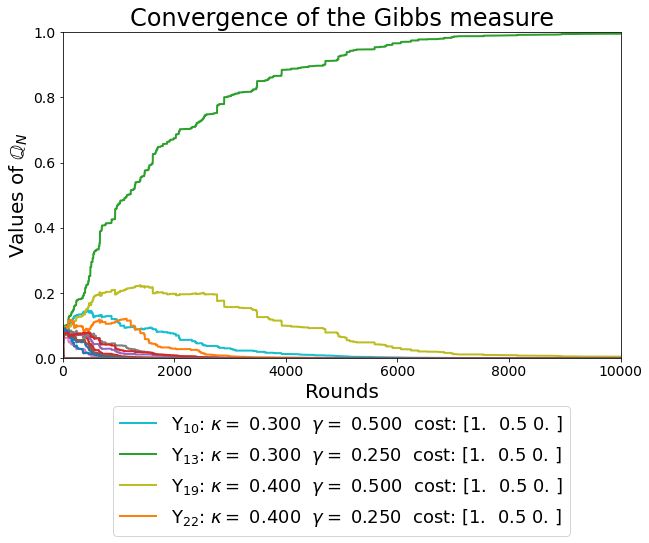

In [11]:
fig, axes = plt.subplots(figsize=(10,6))

# lines
a = gibbs[len(gibbs)//2,:]
legend = ["_nolegend_" if a[i] < np.partition(a, -4)[-4] \
                   else r"$\Upsilon_{{{:2d}}}$".format(i+1)+\
                          r": $\kappa=$ {:.3f}".format(upsilons[i][0])+ \
                          r"  $\gamma=$ {:.3f}".format(upsilons[i][1])+\
                          "  cost: "+ np.array_str(upsilons[i][2], precision=2) for i in range(len(a))]

axes.plot(np.arange(len(gibbs)),
          gibbs,
          linewidth=2.0,
          label=legend)

# aesthetics
axes.set_title('Convergence of the Gibbs measure', fontsize=24)
axes.set_xlabel('Rounds', fontsize=20)
axes.set_ylabel(r"Values of $\mathbb{Q}_{N}$", fontsize=20)
axes.set_xlim(0, len(gibbs))
axes.set_ylim(0, 1)
axes.legend(loc=9, bbox_to_anchor=(0.5,-0.12), fontsize=18)
axes.tick_params(axis='both', labelsize=14)
plt.show()

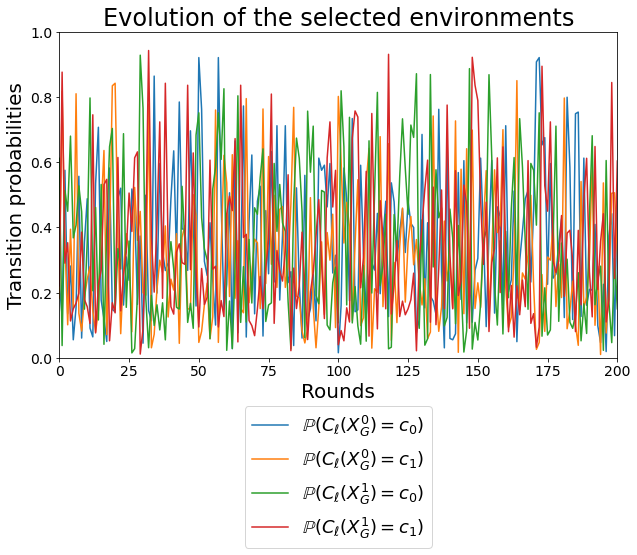

In [12]:
fig, axes = plt.subplots(figsize=(10,6))

# lines
axes.plot(np.arange(len(chosen_Gs)),
          chosen_Gs[:,:,:-1].reshape(len(chosen_Gs),-1),
          linewidth=1.5)

# aesthetics
axes.set_title('Evolution of the selected environments', fontsize = 24)
axes.set_xlabel('Rounds', fontsize=20)
axes.set_ylabel('Transition probabilities', fontsize=20)
axes.set_xlim(0, 200)
axes.set_ylim(0, 1)
axes.tick_params(axis='both', labelsize=14)
axes.legend([r"$\mathbb{P}( C_{\ell}(X^{0}_{G}) = c_0 )$",
             r"$\mathbb{P}( C_{\ell}(X^{0}_{G}) = c_1 )$",
             r"$\mathbb{P}( C_{\ell}(X^{1}_{G}) = c_0 )$",
             r"$\mathbb{P}( C_{\ell}(X^{1}_{G}) = c_1 )$",],
            loc=9, bbox_to_anchor=(0.5,-0.12), fontsize=18)
plt.show()

### Learning algorithm with minimization of power for largest risk-aversions

In this setting, we verify if the Gibbs measure converges faster when designing the next environment by minimizing $\Psi$ between the largest probabilities assigned by $\mathbb{Q}_{N}$.

In [13]:
np.random.seed(1234)
gibbs, chosen_Gs = \
    learn(Gs=Gs,
          psis=psis,
          upsilons=upsilons,
          upsilon0=upsilon0,
          n_rounds=500,
          select_method="largest",
          lr=lr,
          print_progress=50)

Episode:   1; Best criterion:  1 with kappa: 0.20   gamma: 0.50   cost function:  [1.  0.5 0. ]
Gibbs: [0.04 0.01 0.04 0.04 0.01 0.04 0.04 0.01 0.04 0.04 0.01 0.04 0.04 0.01
 0.04 0.04 0.01 0.04 0.04 0.01 0.04 0.04 0.01 0.04 0.04 0.01 0.04 0.04
 0.01 0.04 0.04 0.01 0.04 0.04 0.01 0.04]
Episode:  51; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.09 0.   0.   0.67 0.
 0.   0.   0.   0.   0.09 0.   0.   0.09 0.   0.   0.   0.   0.   0.01
 0.   0.   0.   0.   0.   0.01 0.   0.  ]
Episode: 101; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.96 0.
 0.   0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Episode: 151; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.

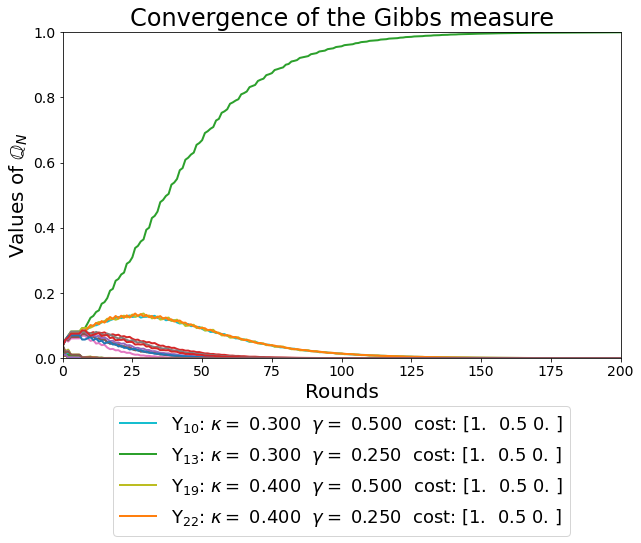

In [14]:
fig, axes = plt.subplots(figsize=(10,6))

# lines
a = gibbs[len(gibbs)//2,:]
legend = ["_nolegend_" if a[i] < np.partition(a, -4)[-4] \
                   else r"$\Upsilon_{{{:2d}}}$".format(i+1)+\
                          r": $\kappa=$ {:.3f}".format(upsilons[i][0])+ \
                          r"  $\gamma=$ {:.3f}".format(upsilons[i][1])+\
                          "  cost: "+ np.array_str(upsilons[i][2], precision=2) for i in range(len(a))]

axes.plot(np.arange(len(gibbs)),
          gibbs,
          linewidth=2.0,
          label=legend)

# aesthetics
axes.set_title('Convergence of the Gibbs measure', fontsize=24)
axes.set_xlabel('Rounds', fontsize=20)
axes.set_ylabel(r"Values of $\mathbb{Q}_{N}$", fontsize=20)
axes.set_xlim(0, 200)
axes.set_ylim(0, 1)
axes.legend(loc=9, bbox_to_anchor=(0.5,-0.12), fontsize=18)
axes.tick_params(axis='both', labelsize=14)
plt.show()

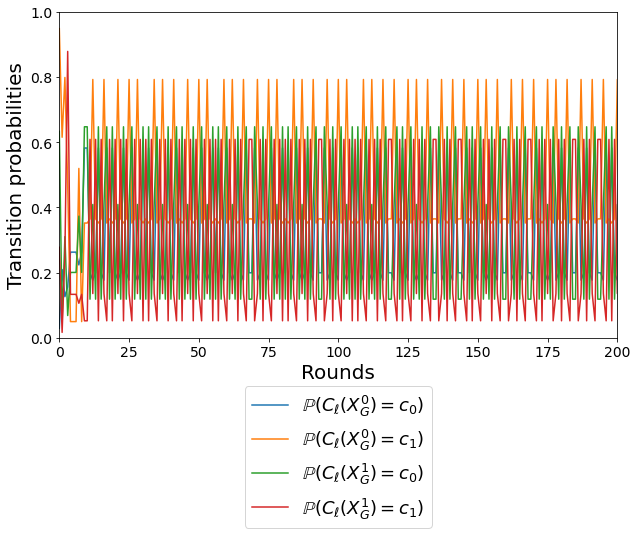

In [15]:
fig, axes = plt.subplots(figsize=(10,6))

# lines
axes.plot(np.arange(len(chosen_Gs)),
          chosen_Gs[:,:,:-1].reshape(len(chosen_Gs),-1),
          linewidth=1.5)

# aesthetics
# axes.set_title('Evolution of the selected environments', fontsize = 24)
axes.set_xlabel('Rounds', fontsize=20)
axes.set_ylabel('Transition probabilities', fontsize=20)
axes.set_xlim(0, 200)
axes.set_ylim(0, 1)
axes.tick_params(axis='both', labelsize=14)
axes.legend([r"$\mathbb{P}( C_{\ell}(X^{0}_{G}) = c_0 )$",
             r"$\mathbb{P}( C_{\ell}(X^{0}_{G}) = c_1 )$",
             r"$\mathbb{P}( C_{\ell}(X^{1}_{G}) = c_0 )$",
             r"$\mathbb{P}( C_{\ell}(X^{1}_{G}) = c_1 )$",],
            loc=9, bbox_to_anchor=(0.5,-0.12), fontsize=18)
plt.show()

### Learning algorithm with minimization of expected power

In this setting, we verify if the Gibbs measure converges faster when designing the next environment by minimizing the expected $\Psi$ under $\mathbb{Q}_{N}$.

In [16]:
np.random.seed(1234)
gibbs, chosen_Gs = \
    learn(Gs=Gs,
          psis=psis,
          upsilons=upsilons,
          upsilon0=upsilon0,
          n_rounds=500,
          select_method="expected",
          lr=lr,
          print_progress=50)

Episode:   1; Best criterion:  1 with kappa: 0.20   gamma: 0.50   cost function:  [1.  0.5 0. ]
Gibbs: [0.04 0.04 0.   0.04 0.04 0.   0.04 0.04 0.   0.04 0.04 0.   0.04 0.04
 0.   0.04 0.04 0.   0.04 0.04 0.   0.04 0.04 0.   0.04 0.04 0.   0.04
 0.04 0.   0.04 0.04 0.   0.04 0.04 0.  ]
Episode:  51; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.05 0.   0.   0.45 0.
 0.   0.   0.   0.   0.26 0.   0.   0.12 0.   0.   0.01 0.   0.   0.05
 0.   0.   0.   0.   0.   0.05 0.   0.  ]
Episode: 101; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.98 0.
 0.   0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Episode: 151; Best criterion: 13 with kappa: 0.30   gamma: 0.25   cost function:  [1.  0.5 0. ]
Gibbs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.

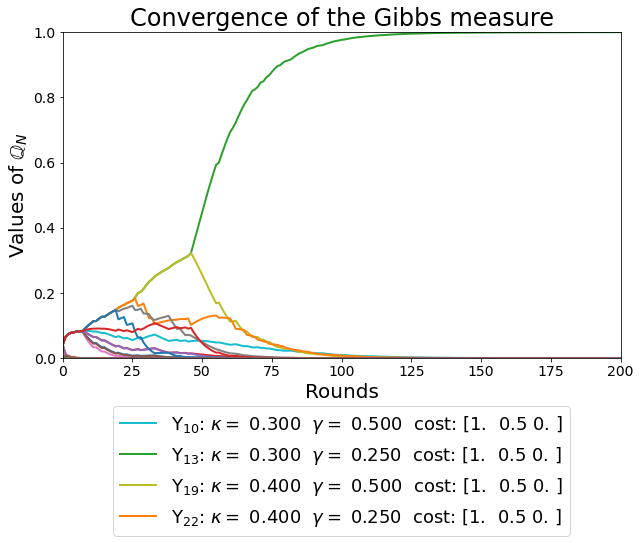

In [17]:
fig, axes = plt.subplots(figsize=(10,6))

# lines
a = gibbs[len(gibbs)//2,:]
legend = ["_nolegend_" if a[i] < np.partition(a, -4)[-4] \
                   else r"$\Upsilon_{{{:2d}}}$".format(i+1)+\
                          r": $\kappa=$ {:.3f}".format(upsilons[i][0])+ \
                          r"  $\gamma=$ {:.3f}".format(upsilons[i][1])+\
                          "  cost: "+ np.array_str(upsilons[i][2], precision=2) for i in range(len(a))]

axes.plot(np.arange(len(gibbs)),
          gibbs,
          linewidth=2.0,
          label=legend)

# aesthetics
axes.set_title('Convergence of the Gibbs measure', fontsize=24)
axes.set_xlabel('Rounds', fontsize=20)
axes.set_ylabel(r"Values of $\mathbb{Q}_{N}$", fontsize=20)
axes.set_xlim(0, 200)
axes.set_ylim(0, 1)
axes.legend(loc=9, bbox_to_anchor=(0.5,-0.12), fontsize=18)
axes.tick_params(axis='both', labelsize=14)
plt.show()

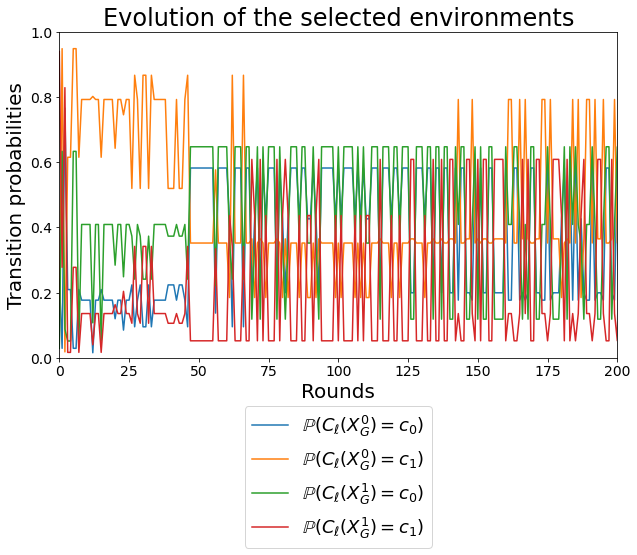

In [18]:
fig, axes = plt.subplots(figsize=(10,6))

# lines
axes.plot(np.arange(len(chosen_Gs)),
          chosen_Gs[:,:,:-1].reshape(len(chosen_Gs),-1),
          linewidth=1.5)

# aesthetics
axes.set_title('Evolution of the selected environments', fontsize = 24)
axes.set_xlabel('Rounds', fontsize=20)
axes.set_ylabel('Transition probabilities', fontsize=20)
axes.set_xlim(0, 200)
axes.set_ylim(0, 1)
axes.tick_params(axis='both', labelsize=14)
axes.legend([r"$\mathbb{P}( C_{\ell}(X^{0}_{G}) = c_0 )$",
             r"$\mathbb{P}( C_{\ell}(X^{0}_{G}) = c_1 )$",
             r"$\mathbb{P}( C_{\ell}(X^{1}_{G}) = c_0 )$",
             r"$\mathbb{P}( C_{\ell}(X^{1}_{G}) = c_1 )$",],
            loc=9, bbox_to_anchor=(0.5,-0.12), fontsize=18)
plt.show()

### Convergence speed visualizations

In this setting, we perform multiple runs of the learning algorithm for the different environment-design rules. This allows an estimation of the distribution for $\mathbb{Q}_{n}(\{0\})$, i.e. the Gibbs measure value for the agent's true risk-aversion, at each round.

In [19]:
np.random.seed(4321)
n_runs = 10
n_rounds1 = 5_000
n_rounds2 = 500
n_envs = 500
lr = 4

idx_upsilon0 = [idx for idx,ii in enumerate(upsilons) if (ii[0] == upsilon0[0]) and \
                                                            (ii[1] == upsilon0[1]) and \
                                                            (ii[2] == upsilon0[2]).all()][0]

unif_gibbs = np.zeros((n_runs,n_rounds1,len(upsilons)))
largest_gibbs = np.zeros((n_runs,n_rounds2,len(upsilons)))
expected_gibbs = np.zeros((n_runs,n_rounds2,len(upsilons)))
    
for run in range(n_runs):
    
    print("\rProgress: run #{:5d} of {:5d}".format(run+1, n_runs), end="")
    
    z = np.random.randn(n_envs, n_actions, n_states)
    Gs = np.exp(z) / np.sum(np.exp(z), axis=2, keepdims=True)

    psis = compute_power(Gs, upsilons)

    unif_gibbs[run,...], _ = \
        learn(Gs=Gs,
              psis=psis,
              upsilons=upsilons,
              upsilon0=upsilon0,
              n_rounds=n_rounds1,
              select_method="random",
              lr=lr)
    largest_gibbs[run,...], _ = \
        learn(Gs=Gs,
              psis=psis,
              upsilons=upsilons,
              upsilon0=upsilon0,
              n_rounds=n_rounds2,
              select_method="largest",
              lr=lr)
    expected_gibbs[run,...], _ = \
        learn(Gs=Gs,
              psis=psis,
              upsilons=upsilons,
              upsilon0=upsilon0,
              n_rounds=n_rounds2,
              select_method="expected",
              lr=lr)

print(" Done.")

Progress: run #   10 of    10 Done.


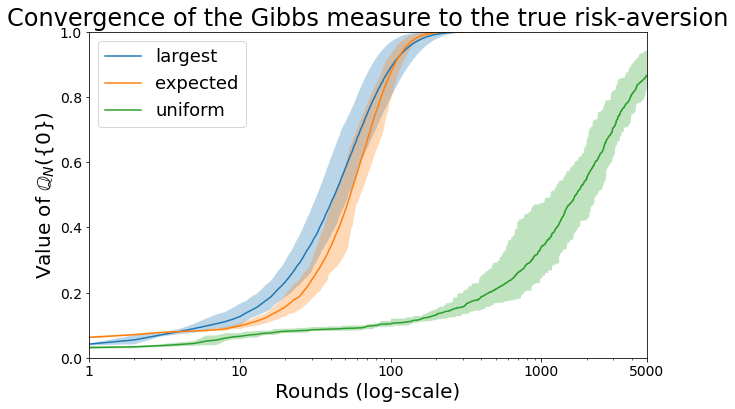

In [20]:
fig, axes = plt.subplots(figsize=(10,6))

largest_upsilon0 = largest_gibbs[...,idx_upsilon0]
expected_upsilon0 = expected_gibbs[...,idx_upsilon0]
unif_upsilon0 = unif_gibbs[...,idx_upsilon0]

# lines
axes.plot(np.arange(n_rounds2),
          np.mean(largest_upsilon0, axis=0),
          label='largest', color='C0', linewidth=1.5)
axes.plot(np.arange(n_rounds2),
          np.mean(expected_upsilon0, axis=0),
          label='expected', color='C1', linewidth=1.5)
axes.plot(np.arange(n_rounds1),
          np.mean(unif_upsilon0, axis=0),
          label='uniform', color='C2', linewidth=1.5)

# shades
axes.fill_between(np.arange(n_rounds2),
                  np.quantile(largest_upsilon0, 0.9, axis=0),
                  np.quantile(largest_upsilon0, 0.1, axis=0),
                  facecolor='C0', alpha=0.3)
axes.fill_between(np.arange(n_rounds2),
                  np.quantile(expected_upsilon0, 0.9, axis=0),
                  np.quantile(expected_upsilon0, 0.1, axis=0),
                  facecolor='C1', alpha=0.3)
axes.fill_between(np.arange(n_rounds1),
                  np.quantile(unif_upsilon0, 0.9, axis=0),
                  np.quantile(unif_upsilon0, 0.1, axis=0),
                  facecolor='C2', alpha=0.3)

# aesthetics
axes.set_title('Convergence of the Gibbs measure to the true risk-aversion', fontsize = 24)
axes.set_xlabel('Rounds (log-scale)', fontsize=20)
axes.set_ylabel(r"Value of $\mathbb{Q}_{N}(\{0\})$", fontsize=20)
axes.legend(loc='upper left', fontsize=18)
axes.set_xlim(1, n_rounds1)
axes.set_xscale('log')
axes.xaxis.set_major_formatter(ScalarFormatter())
axes.set_xticks([1,10,100,1000,5000])
axes.set_ylim(0, 1)
axes.tick_params(axis='both', labelsize=14)
plt.show()